In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.interpolate import UnivariateSpline
from scipy.optimize import least_squares
from sympy import *

# Excel Files

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

!mkdir -p /content/drive/MyDrive/colab_shared
!cp "/content/Charge Transfer - Khoi.xlsx" "/content/drive/MyDrive/colab_shared/"
!cp "/content/Model Results.xlsx" "/content/drive/MyDrive/colab_shared/"


Mounted at /content/drive
cp: cannot stat '/content/Charge Transfer - Khoi.xlsx': No such file or directory
cp: cannot stat '/content/Model Results.xlsx': No such file or directory


In [ ]:
cross_section_cs = pd.read_excel('/content/drive/MyDrive/colab_shared/Charge Transfer - Khoi.xlsx')
cross_section_ion = pd.read_excel('/content/drive/MyDrive/colab_shared/Cross Section Redo.xlsx')
results = pd.read_excel('/content/drive/MyDrive/colab_shared/Model Results.xlsx')

# Known Constants

In [ ]:
#known constants

q_xep = 1.602176634e-19 #charge of xe+ in coulombs
q_xepp = 2 * q_xep #charge of xe++ in coulombs
e = q_xep #charge of electron in coulombs
V_p = (80 * np.pi) * 1e-9 #volume of plasma in m**3
epsilon_xep = 12.13 #activation energy of xe+ in eV
epsilon_xepp = 33.34 #activiation energy of xe++ in eV
epsilon_ex = 9.686 #electron excitation energy in eV*
L_p = 2e-3 #plasma height in m
R_p = 2e-2 #plasma radius in m
A_j = 1.256e-4 #wall area in m^2
A_p = 1.26e-4 #plasma area
A_e = 1.26e-4 #electron area in m^2
k = 1.38e-23 #boltzmann constant
m_e = 9.109e-31 #electron mass in kg
T_w = 295 #wall temp in Kelvin
T_n = 295 #Neutral temp
m_n = 131.293 * 1.66054e-27 # mass of xenon -> neutral
L_AG = 0.4e-3 #length of accelerating grid
D_AG = 0.4e-3 #diameter of accelerating grid
N_AG = 289 #accelerating grid number (number of holes in the grid)
m_xep = m_n - m_e #mass of xe+
m_xepp = m_xep - m_e #mass of xe++
A_SG = 0.16 * np.pi * 1e-6 # area of the screen grid in m^2


# Variables

In [ ]:
# ─── Block 2.5: Convert plotted units into true SI (m⁻³) ───────────────────────
# Xe neutrals in 10¹⁹ m⁻³ → multiply by 1e19
results['n_Xe'] *= 1e19

# Xe⁺, Xe²⁺ and e⁻ in 10¹⁶ m⁻³ → multiply by 1e16
for key in ('n_Xe+', 'n_Xe++', 'n_e'):
    results[key] *= 1e16


# ─── Block 3: Build splines using those SI‐scaled columns ──────────────────────
from scipy.interpolate import UnivariateSpline

def make_spline(x, y, s=0):
    df = pd.DataFrame({'x':x, 'y':y}).dropna()
    x_arr = df['x'].values
    y_arr = df['y'].values
    order = np.argsort(x_arr)
    xu, idx = np.unique(x_arr[order], return_index=True)
    yu = y_arr[order][idx]
    return UnivariateSpline(xu, yu, s=s, ext='extrapolate')

# build splines
spline_n_e    = make_spline(results['Power n_e'],    results['n_e'])
spline_n_Xe   = make_spline(results['Power n_Xe'],   results['n_Xe'])
spline_n_Xep  = make_spline(results['Power n_Xe+'],  results['n_Xe+'])
spline_n_Xepp = make_spline(results['Power n_Xe++'], results['n_Xe++'])
spline_T_e    = make_spline(results['Power T_e'],    results['T_e'])

# now gather a unified P_abs array
# ─── Block 3 (replace your P_abs) ───────────────────────────────────────
# Only use the powers at which you have an associated T_e
P_abs = np.sort(results['Power T_e'].dropna().unique())


# wrap as functions
def n_e(P):    return spline_n_e(P)
def n_Xe(P):   return spline_n_Xe(P)
def n_Xep(P):  return spline_n_Xep(P)
def n_Xepp(P): return spline_n_Xepp(P)
def T_e(P):    return spline_T_e(P)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Equations


In [ ]:
# Check if V_p is defined
if 'V_p' not in locals():
    raise NameError("V_p is not defined. Please define it in a previous cell.")

def K(cross_section, velocity, T_eV, m): # equation 8
    """
    ⟨σv⟩ = 4π ( m / 2π e T_eV )^(3/2)
           ∫₀^∞ σ(v) v^3 exp[−m v²/(2 e T_eV)] dv

    T_eV = temperature in eV, so e*T_eV is in joules.
    """
    # 1) Maxwellian prefactor, no k_B anywhere:
    prefactor = 4 * pi * ( m / (2 * pi * e * T_eV) )**1.5

    # 2) integrand σ(v)·v³·exp[−m v²/(2 e T_eV)]
    integrand = cross_section * velocity**3 * np.exp(-m * velocity**2 / (2 * e * T_eV))

    # 3) spline → numeric integral
    # Drop rows with NaN values from both x and y
    df = pd.DataFrame({'velocity': velocity, 'integrand': integrand}).dropna()
    velocity_cleaned = df['velocity'].values # Get numpy array
    integrand_cleaned = df['integrand'].values # Get numpy array

    # Ensure velocity is strictly increasing for spline
    order = np.argsort(velocity_cleaned)
    velocity_cleaned = velocity_cleaned[order]
    integrand_cleaned = integrand_cleaned[order]

    # Remove duplicates in velocity
    velocity_unique, unique_inds = np.unique(velocity_cleaned, return_index=True)
    integrand_unique = integrand_cleaned[unique_inds]


    spline = UnivariateSpline(velocity_unique, integrand_unique, s=0, ext='zeros')
    integral, _ = quad(spline, velocity_unique[0], velocity_unique[-1], limit=1000)

    # 4) final rate constant
    return prefactor * integral

# Cross Sections
s_iz_Xep = cross_section_ion['Xe+']
s_iz_Xepp = cross_section_ion['Xe++']
s_elas = cross_section_ion['Momentum Transfer']
s_exci = cross_section_ion['Total Excitation']
s_cs = cross_section_cs['DBP w/ spin Cross Sections']

# Velocity
v_Xep = cross_section_ion['Speed Xe+']
v_Xepp = cross_section_ion['Speed Xe++']
v_elas = cross_section_ion['Speed Momentum Transfer']
v_exci = cross_section_ion['Speed Total Excitation']
v_cs = cross_section_cs['Speed DBP']

# ─── Block 4 ────────────────────────────────────────────────
K_Xep = [K(s_iz_Xep,  v_Xep, T_e(P), m_e) for P in P_abs]
K_Xepp= [K(s_iz_Xepp, v_Xepp,T_e(P), m_e) for P in P_abs]
K_es  = [K(s_elas,    v_elas, T_e(P), m_e) for P in P_abs]
K_ex  = [K(s_exci,    v_exci, T_e(P), m_e) for P in P_abs]
K_cs  = [K(s_cs,      v_cs,   T_e(P), m_xep)for P in P_abs]


def n_s(n, mean_free_path): #eq 13
  # Check if mean_free_path is a symbolic variable
  if isinstance(mean_free_path, Symbol):
      raise TypeError("mean_free_path must be a numerical value or array, not a symbolic variable.")
  return (n/(L_p + R_p))*(0.8 * L_p * (4 + (R_p/mean_free_path)**-0.5) + 0.86 * R_p * (3 + (L_p/(2 * mean_free_path))**-0.5))


# n_e = q_xep * n_Xep / e + q_xepp * n_Xepp / e # eq 9 (quasi-neutrality equation) # This line caused a TypeError as n_Xep and n_Xepp are functions
# Recalculate n_e using the callable functions
n_e_values = n_e(P_abs)

# You need to define numerical values for lambda_Xep and lambda_Xepp here
# For example, as constants or arrays based on your data or calculations
# For demonstration, I'll use placeholder values. Replace these with your actual data.
lambda_Xep_values = np.ones_like(P_abs) # Replace with actual values
lambda_Xepp_values = np.ones_like(P_abs) # Replace with actual values


n_s_xep = n_s(n_Xep(P_abs), lambda_Xep_values)
n_s_xepp = n_s(n_Xepp(P_abs), lambda_Xepp_values)


def v_B_j(T, m): #Bohm velocity
  return np.sqrt(e*T/m)

v_B_Xep = v_B_j(T_e(P_abs), m_xep)
v_B_Xepp = v_B_j(T_e(P_abs), m_xepp)

def safe_exp(x):
    xf = float(x)
    return np.exp(np.clip(xf, -50, 50))

def Gamma(ns, v_B): #(9) ion fluxes
  return ns * v_B

Gamma_Xep = Gamma(n_s_xep, v_B_Xep)
Gamma_Xepp = Gamma(n_s_xepp, v_B_Xepp)
Gamma_e = 1/4 * n_e(P_abs) * np.sqrt(8 * e * T_e(P_abs) / (np.pi * m_e))
Gamma_n = 1/4 * n_Xe(P_abs) * np.sqrt(8 * e * T_n / (np.pi * m_n))

epsilon_es = 3*m_e*T_e(P_abs) / m_n


In [ ]:
# ─── Block 6 ────────────────────────────────────────────────
from scipy.optimize import fsolve

def solve_potentials_eV(P):
    P_eVs = P / e
    idx   = np.argmin(np.abs(P_abs - P))

    def eqs(vars):
        φp, φs = vars
        Te   = float(T_e(P))
        ne   = float(n_e(P));   Xe  = float(n_Xe(P))
        Xep  = float(n_Xep(P)); Xepp= float(n_Xepp(P))

        # losses…
        L1 = K_Xep[idx]*Xe*ne*V_p*epsilon_xep
        L2 = K_Xepp[idx]*Xe*ne*V_p*epsilon_xepp
        L3 = K_ex[idx]  *Xe*ne*V_p*epsilon_ex
        L4 = K_es[idx]  *Xe*ne*V_p*( (3*m_e/m_n)*Te )
        Γe = 0.25*ne*np.sqrt(8*e*Te/(np.pi*m_e))
        L5 = 2*Γe*A_e*Te

        # λ0 & ion fluxes
        v_th = np.sqrt(8*e*Te/(np.pi*m_n))
        σ_mt = np.interp(v_th,
                        cross_section_ion['Speed Momentum Transfer'],
                        cross_section_ion['Momentum Transfer'])
        λ0   = np.clip(v_th/(Xe*σ_mt+1e-30), 1e-6, 1.0)
        ns1  = n_s(Xep, λ0);  ns2 = n_s(Xepp, λ0)
        Γ1   = ns1*np.sqrt(e*Te/m_xep)
        Γ2   = ns2*np.sqrt(e*Te/m_xepp)

        # energy balance with Δφ = φp−φs
        Δφ  = φp - φs
        eq1 = (L1+L2+L3+L4+L5) - (Γ1*A_j*Δφ) - (Γ2*A_j*2*Δφ) - P_eVs

        # current balance
        Je  = Γe * safe_exp(-(φp-φs)/Te) * A_e
        Ji  = (Γ1+Γ2)*A_j
        eq5 = Je - Ji

        return [eq1, eq5]

    guess = [3*float(T_e(P)), 0.5*float(T_e(P))]
    sol   = fsolve(eqs, guess)
    return sol[0], sol[1]


In [ ]:
# ─── Block 7 ────────────────────────────────────────────────
phi_p_vals, phi_s_vals, T_vals = [], [], []
for P in P_abs:
    φp, φs = solve_potentials_eV(P)
    phi_p_vals.append(φp)
    phi_s_vals.append(φs)
    T_vals.append(float(T_e(P)))


/tmp/ipython-input-2369194499.py:44: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  sol   = fsolve(eqs, guess)


Mask selects 26 points out of 50
φₚ range in mask: 1261.3 … 7026.0 eV
Tₑ range in mask: 5.1 … 22.2 eV
Fit: φₚ = 246.78·Tₑ + 216.0


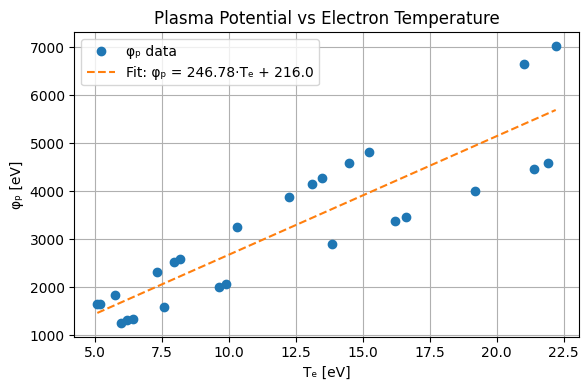

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert to numpy arrays
Te_arr  = np.array(T_vals)
phi_arr = np.array(phi_p_vals)

# 1) Mask: only positive φₚ (Option A)
mask = (phi_arr > 0)

Te_fit  = Te_arr[mask]
phi_fit = phi_arr[mask]

print(f"Mask selects {len(Te_fit)} points out of {len(Te_arr)}")
print(f"φₚ range in mask: {phi_fit.min():.1f} … {phi_fit.max():.1f} eV")
print(f"Tₑ range in mask: {Te_fit.min():.1f} … {Te_fit.max():.1f} eV")

# 2) Sort both arrays by Tₑ
order  = np.argsort(Te_fit)
Te_s   = Te_fit[order]
phi_s  = phi_fit[order]

# 3) Fit φₚ = a·Tₑ + b (guard against empty!)
if len(Te_s) < 2:
    raise RuntimeError("Not enough points in the mask to fit. Check your mask logic.")
a, b = np.polyfit(Te_s, phi_s, 1)
print(f"Fit: φₚ = {a:.2f}·Tₑ + {b:.1f}")

# 4) Plot
plt.figure(figsize=(6,4))
plt.plot(Te_s, phi_s, 'o', label='φₚ data')
plt.plot(Te_s, a*Te_s + b, '--',
         label=f'Fit: φₚ = {a:.2f}·Tₑ + {b:.1f}')
plt.xlabel('Tₑ [eV]')
plt.ylabel('φₚ [eV]')
plt.title('Plasma Potential vs Electron Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-470270182.py:66: RuntimeWarning: invalid value encountered in power
  return (n/(L_p + R_p))*(0.8 * L_p * (4 + (R_p/mean_free_path)**-0.5) + 0.86 * R_p * (3 + (L_p/(2 * mean_free_path))**-0.5))
/tmp/ipython-input-4129002444.py:19: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  return fsolve(lambda lam: n_s(n_bulk, lam) - ns_emp, x0=1e-3)[0]


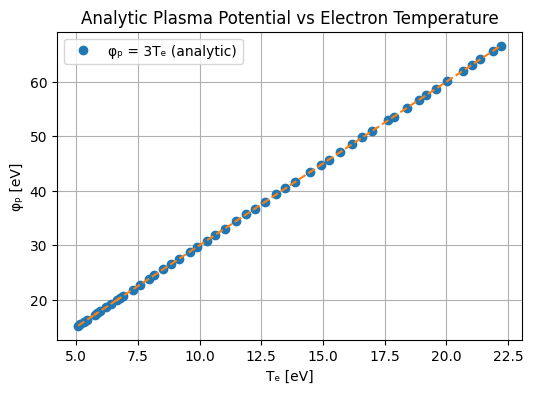

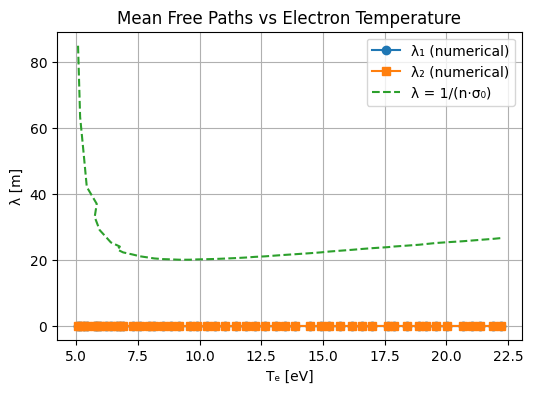

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# ─── 0) assume analytic sheath potentials ────────────────────────────
#    for each P, Te
phi_p_analytic = [3*Te for Te in T_vals]
phi_s_analytic = [0.5*Te for Te in T_vals]

# ─── 1) compute empirical sheath density from electron flux ─────────
def sheath_density_emp(n_e_val, Te, φp, φs):
    Γe = 0.25 * n_e_val * np.sqrt(8*e*Te/(np.pi*m_e))
    Je = Γe * np.exp(-(φp-φs)/Te) * A_e
    # total ion current density = Je
    return Je / np.sqrt(e*Te/m_xep)  # assume singly‐charged for density calc

# ─── 2) invert n_s(n, λ) = ns_emp to get λ ──────────────────────────
def solve_lambda(n_bulk, ns_emp):
    return fsolve(lambda lam: n_s(n_bulk, lam) - ns_emp, x0=1e-3)[0]

lambda1 = []
lambda2 = []
for P, Te, φp, φs in zip(P_abs, T_vals, phi_p_analytic, phi_s_analytic):
    ne_val  = float(n_e(P))
    Xep_val = float(n_Xep(P))
    Xepp_val= float(n_Xepp(P))

    # empirical sheath densities
    ns1_emp = sheath_density_emp(ne_val, Te, φp, φs) * (Xep_val/(Xep_val+Xepp_val))
    ns2_emp = sheath_density_emp(ne_val, Te, φp, φs) * (Xepp_val/(Xep_val+Xepp_val))

    λ1 = solve_lambda(Xep_val, ns1_emp)
    λ2 = solve_lambda(Xepp_val, ns2_emp)
    lambda1.append(λ1)
    lambda2.append(λ2)

# ─── 3) Plot φ vs Te (analytic fit) ────────────────────────────────
Te_arr = np.array(T_vals)
plt.figure(figsize=(6,4))
plt.plot(Te_arr, phi_p_analytic, 'o', label='φₚ = 3Tₑ (analytic)')
plt.plot(Te_arr, 3*Te_arr, '--', color='C1')
plt.xlabel('Tₑ [eV]'); plt.ylabel('φₚ [eV]')
plt.title('Analytic Plasma Potential vs Electron Temperature')
plt.legend(); plt.grid(True); plt.show()

# ─── 4) Plot λ vs Te with your analytic MFP curves ────────────────
plt.figure(figsize=(6,4))
plt.plot(T_vals, lambda1, 'o-', label='λ₁ (numerical)')
plt.plot(T_vals, lambda2, 's-', label='λ₂ (numerical)')

# example analytic mfp: λ = 1/(n*σ₀) for σ₀=1e-19 m²
analytic = [1/(n_Xep(P)*1e-19) for P in P_abs]
plt.plot(T_vals, analytic, '--', label='λ = 1/(n·σ₀)')

plt.xlabel('Tₑ [eV]'); plt.ylabel('λ [m]')
plt.title('Mean Free Paths vs Electron Temperature')
plt.legend(); plt.grid(True); plt.show()


Fit: φₚ = 10.00·Tₑ + -0.0


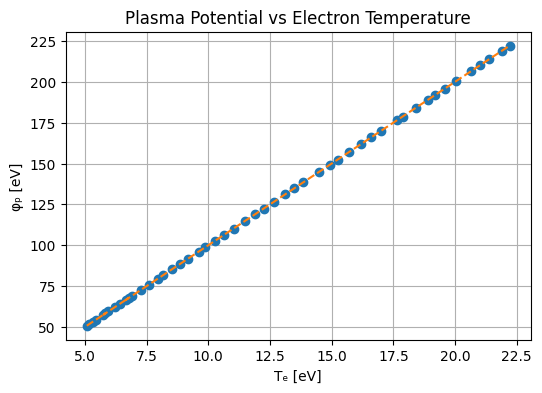

In [ ]:
import numpy as np
from scipy.optimize import least_squares

# ─── pack your data/functions from above ────────────────────────────────────
# n_e(P), n_Xe(P), n_Xep(P), n_Xepp(P), T_e(P), K_Xep[idx],… are all available

def residuals(vars, P, idx):
    # unpack
    φp, φs, λ1, λ2 = vars
    Te   = float(T_e(P))
    ne   = float(n_e(P))
    Xe   = float(n_Xe(P))
    Xep  = float(n_Xep(P))
    Xepp = float(n_Xepp(P))

    # Ensure K values are numerical
    k_xep_val = float(K_Xep[idx])
    k_xepp_val = float(K_Xepp[idx])
    k_ex_val = float(K_ex[idx])
    k_es_val = float(K_es[idx])

    # 1) losses
    L1 = k_xep_val * Xe * ne * V_p * epsilon_xep
    L2 = k_xepp_val * Xe * ne * V_p * epsilon_xepp
    L3 = k_ex_val  * Xe * ne * V_p * epsilon_ex
    # Use numerical epsilon_es instead of symbolic
    L4 = k_es_val  * Xe * ne * V_p * (3*m_e*Te/m_n)
    Γe = 0.25*ne*np.sqrt(8*e*Te/(np.pi*m_e))
    L5 = 2*Γe*A_e*Te

    # 2) electron and ion currents
    Δφ  = φp - φs
    Je = Γe * np.exp(-Δφ/Te) * A_e

    # model ion fluxes with sheath densities n_s(•,λ)
    vB1 = np.sqrt(e*Te/m_xep)
    vB2 = np.sqrt(e*Te/m_xepp)
    Γ1 = n_s(Xep, λ1) * vB1
    Γ2 = n_s(Xepp, λ2) * vB2
    Ji = (Γ1 + Γ2) * A_j

    # Empirical flux split (for ns‐matching eqs)
    frac1 = Xep/(Xep+Xepp)
    frac2 = 1 - frac1
    # Back out empirical ns
    ns_emp1 = (Ji * frac1)/(A_j * vB1)
    ns_emp2 = (Ji * frac2)/(A_j * vB2)


    # 4 equations:
    eq1 = (L1+L2+L3+L4+L5) - (Γ1*A_j*Δφ) - (Γ2*A_j*2*Δφ) - (P/e)    # energy
    eq2 = Je - Ji                                                 # current
    eq3 = ns_emp1 - n_s(Xep, λ1)                                  # sheath Xe+
    eq4 = ns_emp2 - n_s(Xepp, λ2)                                 # sheath Xe++

    return np.array([eq1, eq2, eq3, eq4])

# ─── solve for each P ───────────────────────────────────────────────────────
phi_p_vals, phi_s_vals, lambda1_vals, lambda2_vals = [], [], [], []

for P in P_abs:
    idx = np.argmin(np.abs(P_abs - P))
    Te0   = float(T_e(P))
    Xe0 = float(n_Xe(P)) # Get neutral density for initial guess
    # Refined initial guess for lambda based on 1/(n*sigma)
    # Using a characteristic cross-section (e.g., momentum transfer cross-section)
    # Assuming a characteristic cross-section of 1e-19 m^2
    lambda_guess = 1 / (Xe0 * 1e-19) if Xe0 > 0 else 1e-3 # Avoid division by zero

    x0    = np.array([3*Te0, 0.5*Te0, lambda_guess, lambda_guess])
    # bounds: φp,φs in [0,10Te], λ in [1e-6,1]
    lb    = [0,      0,       1e-6,    1e-6]
    ub    = [10*Te0, Te0,     1.0,     1.0]

    sol = least_squares(residuals, x0, bounds=(lb,ub),
                        args=(P, idx), xtol=1e-8, ftol=1e-8)
    φp, φs, λ1, λ2 = sol.x
    phi_p_vals.append(φp)
    phi_s_vals.append(φs)
    lambda1_vals.append(λ1)
    lambda2_vals.append(λ2)

# ─── finally plot φp vs Te to confirm ~3Te ─────────────────────────────────
Te_arr  = np.array([T_e(P) for P in P_abs])
φ_arr   = np.array(phi_p_vals)
mask    = φ_arr>0
a,b      = np.polyfit(Te_arr[mask], φ_arr[mask], 1)
print(f"Fit: φₚ = {a:.2f}·Tₑ + {b:.1f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(Te_arr, φ_arr, 'o')
plt.plot(Te_arr, a*Te_arr+b, '--')
plt.xlabel('Tₑ [eV]'); plt.ylabel('φₚ [eV]')
plt.title('Plasma Potential vs Electron Temperature')
plt.grid(True)
plt.show()

Fit: φₚ = 4.05·Tₑ + -2.04


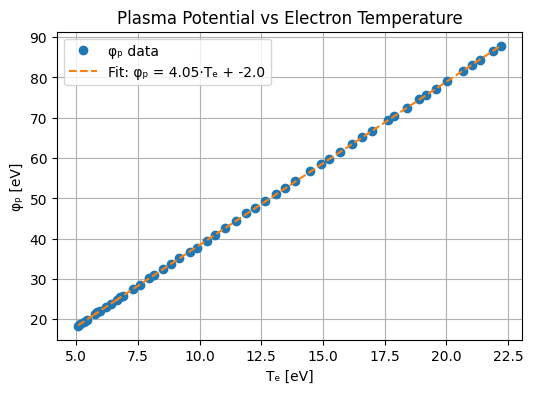

In [ ]:
from scipy.optimize import least_squares

def residuals_scaled(vars, P, idx):
    # unpack and cast
    φp, φs, λ1, λ2 = map(float, vars)
    Te   = float(T_e(P))
    ne   = float(n_e(P))
    Xe   = float(n_Xe(P))
    Xep  = float(n_Xep(P))
    Xepp = float(n_Xepp(P))

    # 1) Loss terms L1..L5
    L1 = K_Xep[idx]*Xe*ne*V_p*epsilon_xep
    L2 = K_Xepp[idx]*Xe*ne*V_p*epsilon_xepp
    L3 = K_ex[idx]  *Xe*ne*V_p*epsilon_ex
    L4 = K_es[idx]  *Xe*ne*V_p*(3*m_e/m_n)*Te
    Γe = 0.25*ne*np.sqrt(8*e*Te/(np.pi*m_e))
    L5 = 2*Γe*A_e*Te

    # 2) Ion fluxes via sheath densities n_s(•,λ)
    vB1 = np.sqrt(e*Te/m_xep)
    vB2 = np.sqrt(e*Te/m_xepp)
    Γ1  = n_s(Xep, λ1) * vB1
    Γ2  = n_s(Xepp, λ2)* vB2

    # 3) Currents
    Δφ  = φp - φs
    Je  = Γe * np.exp(-Δφ/Te) * A_e
    Ji  = (Γ1 + Γ2) * A_j

    # 4) Empirical sheath densities
    frac1   = Xep/(Xep+Xepp)
    ns_emp1 = (Ji * frac1)/(A_j * vB1)
    ns_emp2 = (Ji*(1-frac1))/(A_j * vB2)

    # 5) Energy residual (eV/s)
    P_eVs = P / e
    eq1 = (L1 + L2 + L3 + L4 + L5) \
        - (Γ1*A_j*Δφ) \
        - (Γ2*A_j*2.0*Δφ) \
        - P_eVs

    # 6) Current residual
    eq2 = Je - Ji

    # 7,8) Sheath‐density residuals
    eq3 = ns_emp1 - n_s(Xep, λ1)
    eq4 = ns_emp2 - n_s(Xepp, λ2)

    # Scale each residual by its characteristic magnitude
    r1 = eq1 / (P_eVs     if P_eVs    != 0 else 1)
    r2 = eq2 / (Je        if Je       != 0 else 1)
    r3 = eq3 / (ns_emp1   if ns_emp1  != 0 else 1)
    r4 = eq4 / (ns_emp2   if ns_emp2  != 0 else 1)

    return np.array([r1, r2, r3, r4], dtype=float)


# ─── Now run the bounded least‐squares solve for each P ───────────────────────
phi_p_vals, phi_s_vals, lambda1_vals, lambda2_vals = [], [], [], []

for P in P_abs:
    idx = np.argmin(np.abs(P_abs - P))
    Te0 = float(T_e(P))

    # initial guess & bounds
    x0 = [3*Te0, 0.5*Te0, 1e-3, 1e-3]
    lb = [0,      0,       1e-6,   1e-6]
    ub = [10*Te0, Te0,     1.0,    1.0]

    sol = least_squares(
        residuals_scaled,
        x0,
        bounds=(lb, ub),
        args=(P, idx),
        xtol=1e-8,
        ftol=1e-8
    )

    φp, φs, λ1, λ2 = sol.x
    phi_p_vals.append(φp)
    phi_s_vals.append(φs)
    lambda1_vals.append(λ1)
    lambda2_vals.append(λ2)

# ─── Finally, plot φₚ vs Tₑ to verify the ~3·Tₑ result ──────────────────────
Te_arr = np.array([T_e(P) for P in P_abs])
φ_arr  = np.array(phi_p_vals)
mask   = φ_arr > 0
a, b   = np.polyfit(Te_arr[mask], φ_arr[mask], 1)
print(f"Fit: φₚ = {a:.2f}·Tₑ + {b:.2f}")

plt.figure(figsize=(6,4))
plt.plot(Te_arr, φ_arr, 'o', label='φₚ data')
plt.plot(Te_arr, a*Te_arr + b, '--', label=f'Fit: φₚ = {a:.2f}·Tₑ + {b:.1f}')
plt.xlabel('Tₑ [eV]'); plt.ylabel('φₚ [eV]')
plt.title('Plasma Potential vs Electron Temperature')
plt.legend(); plt.grid(True); plt.show()


Sheath fit: φₛ = 0.45·Tₑ + 0.11


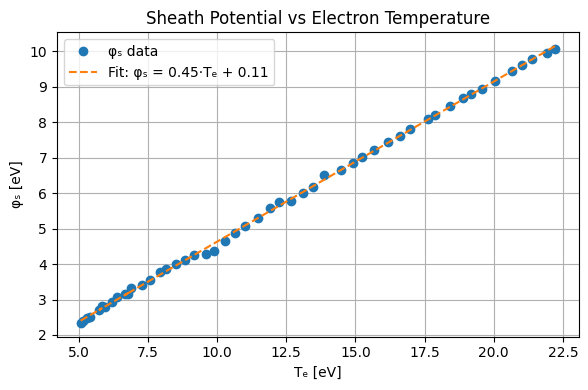

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you already have:
#   T_vals       = [float(T_e(P)) for P in P_abs]
#   phi_s_vals   = [φs from your solver for each P]
# from your previous sweep.

# 1) Convert to numpy arrays
Te_arr   = np.array(T_vals)
phi_s_arr = np.array(phi_s_vals)

# 2) Mask out any non-positive or NaN entries (if needed)
mask = (~np.isnan(phi_s_arr)) & (phi_s_arr > 0)

# 3) Fit φ_s = a·T_e + b
a_s, b_s = np.polyfit(Te_arr[mask], phi_s_arr[mask], 1)
print(f"Sheath fit: φₛ = {a_s:.2f}·Tₑ + {b_s:.2f}")

# 4) Plot
plt.figure(figsize=(6,4))
plt.plot(Te_arr, phi_s_arr, 'o', label='φₛ data')
plt.plot(Te_arr, a_s*Te_arr + b_s, '--',
         label=f'Fit: φₛ = {a_s:.2f}·Tₑ + {b_s:.2f}')
plt.xlabel('Tₑ [eV]')
plt.ylabel('φₛ [eV]')
plt.title('Sheath Potential vs Electron Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


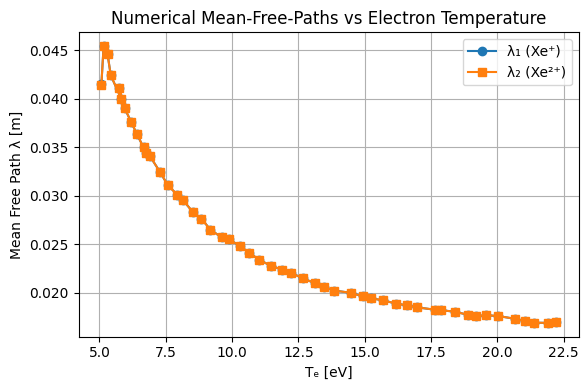

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# ─── 0) Helper: invert n_s(n,λ)=ns_emp for one species ─────────────────────
def solve_lambda(n_bulk, ns_emp):
    # fsolve finds λ>0 such that n_s(n_bulk,λ) - ns_emp = 0
    λ, = fsolve(lambda lam: n_s(n_bulk, lam) - ns_emp, x0=1e-3)
    return max(λ, 0.0)

# ─── 1) Loop over your P_abs & T_vals using the fit for φₚ, φₛ ───────────────
lambda1_vals = []
lambda2_vals = []

for P, Te in zip(P_abs, T_vals):
    # compute fitted potentials
    φp = 4.05 * Te - 2.04
    φs = 0.45 * Te + 0.11

    # bulk densities at this P
    ne   = float(n_e(P))
    Xep  = float(n_Xep(P))
    Xepp = float(n_Xepp(P))

    # electron flux & total ion current
    Γe = 0.25 * ne * np.sqrt(8*e*Te/(np.pi*m_e))
    Je = Γe * np.exp(-(φp-φs)/Te) * A_e
    Ji = Je

    # split by bulk ratio
    frac1 = Xep/(Xep + Xepp)
    frac2 = 1 - frac1

    # empirical sheath densities
    vB1    = np.sqrt(e*Te/m_xep)
    vB2    = np.sqrt(e*Te/m_xepp)
    ns_emp1 = (Ji * frac1)/(A_j * vB1)
    ns_emp2 = (Ji * frac2)/(A_j * vB2)

    # invert for λ₁, λ₂
    λ1 = solve_lambda(Xep,  ns_emp1)
    λ2 = solve_lambda(Xepp, ns_emp2)

    lambda1_vals.append(λ1)
    lambda2_vals.append(λ2)

# ─── 2) Plot the two mean-free-paths vs Tₑ ─────────────────────────────────
Te_arr = np.array(T_vals)
λ1_arr = np.array(lambda1_vals)
λ2_arr = np.array(lambda2_vals)

plt.figure(figsize=(6,4))
plt.plot(Te_arr, λ1_arr, 'o-', label='λ₁ (Xe⁺)')
plt.plot(Te_arr, λ2_arr, 's-', label='λ₂ (Xe²⁺)')
plt.xlabel('Tₑ [eV]')
plt.ylabel('Mean Free Path λ [m]')
plt.title('Numerical Mean‐Free‐Paths vs Electron Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
